note: ha nincs itt 1-1 specifikus részlet az azért van mert nem találtam célszerűnek külön-külön mindet leforditani mivel később is előfordul

a torchtext for some reason megadta magát (eddig tökéletesen működött)

In [ ]:
!pip install torchinfo torchtext

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torchsummary import summary

# import torchtext; torchtext.disable_torchtext_deprecation_warning()
# from torchtext.data.utils import get_tokenizer

import pandas as pd
import string
import re
from collections import Counter
import nltk

import torch.optim as optim
# from torchtext.vocab import build_vocab_from_iterator
from collections import OrderedDict
# from torchtext.transforms import VocabTransform
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

from nltk.corpus import stopwords
from os import listdir
from numpy import array
import matplotlib.pyplot as plt

In [11]:
def clean_text(text):
    # basic cleaning
    tokens = text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w.lower() not in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

def build_vocab_from_df(df, text_column):
    vocab = Counter()
    for text in df[text_column]:
        tokens = clean_text(text)
        vocab.update(tokens)
    return vocab

def pad_sequences(sequences, maxlen, padding_value=0):
    # tldr: pad sequences to the same length
    padded = [seq + [padding_value] * (maxlen - len(seq)) if len(seq) < maxlen else seq[:maxlen] for seq in sequences]
    return torch.tensor(padded, dtype=torch.long).clone().detach()

def train_model(model, dataloader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        for batch_docs, batch_labels in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_docs).squeeze()
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_docs, batch_labels in dataloader:
            outputs = model(batch_docs).squeeze()
            predicted = outputs.round()
            correct += (predicted == batch_labels).sum().item()
            total += batch_labels.size(0)
        accuracy = correct / total
        return accuracy

def yield_tokens(data):
    # for comfort
    for doc in data:
        yield tokenizer(doc)

def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

def clean_doc(doc, vocab=None):
  # clean_text with extra steps
  tokens = doc.split()

  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  tokens = [re_punc.sub('', w) for w in tokens]

  if vocab is None:
    tokens = [word for word in tokens if word.isalpha()]

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
  else:
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
  return tokens

def add_doc_to_vocab(filename, vocab):
  doc = load_doc(filename)
  tokens = clean_doc(doc)
  vocab.update(tokens)

def process_docs_load(directory, vocab):
  for filename in listdir(directory):
    if filename.startswith('cv9'):
      continue
    path = directory + '/' + filename
    add_doc_to_vocab(path, vocab)

def process_docs(directory, vocab, is_train):
  documents = list()
  for filename in listdir(directory):
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    path = directory + '/' + filename
    doc = load_doc(path)
    tokens = clean_doc(doc, vocab)
    documents.append(tokens)
  return documents

def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

def load_clean_dataset(vocab, is_train):
  neg = process_docs('txt_sentoken/neg', vocab, is_train)
  pos = process_docs('txt_sentoken/pos', vocab, is_train)
  docs = neg + pos
  labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
  return docs, labels

def encode_docs(vocab, max_length, docs):
    # integer encoding + padding to max
    encoded = [torch.tensor([vocab[token] for token in doc.split()]) for doc in docs]
    padded = pad_sequence(encoded, batch_first=True, padding_value=vocab['<pad>'])
    if padded.size(1) > max_length:
        padded = padded[:, :max_length]
    else:
        padding = torch.full((padded.size(0), max_length - padded.size(1)), vocab['<pad>'])
        padded = torch.cat((padded, padding), dim=1)
    return padded

def build_vocab(docs):
    # sometimes my genius frightens me
    tokenizer = lambda x: x.split()
    vocab = build_vocab_from_iterator(map(tokenizer, docs), specials=['<pad>'])
    vocab.set_default_index(vocab['<pad>'])
    return vocab

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(10, 10)
        self.lin2 = nn.Linear(10, 20)
        self.lin3 = nn.Linear(20, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, input):
        h1 = F.relu(self.lin1(input))
        h2 = F.relu(self.lin2(h1))
        h3 = F.relu(self.lin3(h2))
        output = torch.sigmoid(self.output(h3))
        return output

model = MLP()

summary(model, input_size=(10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                   [-1, 20]             220
            Linear-3                   [-1, 10]             210
            Linear-4                    [-1, 1]              11
Total params: 551
Trainable params: 551
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.c2p1 = nn.Conv2d(1, 32, kernel_size=4)
        self.p2c1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c2p2 = nn.Conv2d(32, 16, kernel_size=4)
        self.p2lin = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lin1 = nn.Linear(16 * 13 * 13, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, input):
        c1 = F.relu(self.c2p1(input))
        p1 = self.p2c1(c1)
        c2 = F.relu(self.c2p2(p1))
        p2 = self.p2lin(c2)
        p2_flat = p2.view(-1, 16 * 13 * 13)
        h1 = F.relu(self.lin1(p2_flat))
        output = torch.sigmoid(self.output(h1))
        return output

model = CNN()

summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 61, 61]             544
         MaxPool2d-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 16, 27, 27]           8,208
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Linear-5                   [-1, 10]          27,050
            Linear-6                    [-1, 1]              11
Total params: 35,813
Trainable params: 35,813
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.24
Params size (MB): 0.14
Estimated Total Size (MB): 1.39
----------------------------------------------------------------


In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, batch_first=True)
        self.lin1 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        last_hidden_state = lstm_out[:, -1, :]
        h1 = F.relu(self.lin1(last_hidden_state))
        output = torch.sigmoid(self.output(h1))
        return output

model = RNN()

#LSTM-el meggyűlt a baja a torchsummary-nak
torchinfo.summary(model, input_size=(1,100, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 1]                    --
├─LSTM: 1-1                              [1, 100, 10]              520
├─Linear: 1-2                            [1, 10]                   110
├─Linear: 1-3                            [1, 1]                    11
Total params: 641
Trainable params: 641
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [ ]:
text = 'The quick brown fox jumped over the lazy dog.'

tokenizer = get_tokenizer('basic_english')
result = tokenizer(text)
result

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '.']

In [ ]:
df = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/data/not_na_tags/latin_374_w2v.csv?raw=true')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
min_occurane = 2

vocab = build_vocab_from_df(df, 'Question')

print('Vocabulary Size:', len(vocab))
print('Top Words:', vocab.most_common(50))

tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))

Vocabulary Size: 57518
Top Words: [('Latin', 7672), ('would', 3867), ('like', 2709), ('word', 2621), ('one', 2091), ('translation', 1862), ('Im', 1857), ('English', 1745), ('words', 1647), ('used', 1628), ('know', 1560), ('Greek', 1519), ('use', 1514), ('question', 1495), ('meaning', 1421), ('say', 1414), ('something', 1364), ('et', 1317), ('also', 1216), ('mean', 1178), ('verb', 1176), ('could', 1156), ('seems', 1147), ('two', 1144), ('est', 1141), ('phrase', 1140), ('sentence', 1124), ('example', 1113), ('translate', 1058), ('way', 1050), ('first', 1015), ('correct', 1008), ('find', 950), ('see', 836), ('sense', 826), ('dont', 813), ('form', 807), ('case', 800), ('found', 793), ('think', 791), ('means', 790), ('make', 778), ('different', 763), ('following', 722), ('name', 704), ('want', 689), ('noun', 686), ('good', 678), ('might', 672), ('understand', 663)]
25297


In [13]:
class SimpleNN(nn.Module):
    def __init__(self, vocab_size, embed_size, max_length):
        super(SimpleNN, self).__init__()
        self.embed = torch.nn.Embedding(vocab_size,embed_size,padding_idx=vocab['<pad>'])
        self.flatten = torch.nn.Flatten()
        self.lin1 = nn.Linear(max_length * embed_size, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input):
        embedded = self.embed(input)
        flattened = self.flatten(embedded)
        h1 = self.lin1(flattened)
        output = self.sigmoid(h1)
        return output

In [ ]:
docs = ['Well done!',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.']

labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

embed_size = 8
max_length = 4
num_epochs = 50

In [ ]:
tokenizer = get_tokenizer('basic_english')

# vocab
vocab = build_vocab_from_iterator(yield_tokens(docs), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

# encoding
encoded_docs = [vocab(tokenizer(doc)) for doc in docs]
print(encoded_docs,'\n')

# padding, might try padding layer in NN
padded_docs = pad_sequence([torch.tensor(doc) for doc in encoded_docs], batch_first=True, padding_value=vocab['<pad>'])
padded_docs = padded_docs[:, :max_length]
print(padded_docs,'\n')

if isinstance(labels,list):
  labels = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(padded_docs, labels)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

model = SimpleNN(vocab_size=len(vocab), embed_size=embed_size, max_length=max_length)

input_tensor = torch.randint(0, len(vocab), (1, max_length))
print(torchinfo.summary(model, input_data=input_tensor))

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

[[17, 4, 2], [6, 3], [12, 5], [14, 3], [11, 2], [16], [7, 5, 2], [15, 6], [7, 3], [10, 13, 4, 9, 8]] 

tensor([[17,  4,  2,  1],
        [ 6,  3,  1,  1],
        [12,  5,  1,  1],
        [14,  3,  1,  1],
        [11,  2,  1,  1],
        [16,  1,  1,  1],
        [ 7,  5,  2,  1],
        [15,  6,  1,  1],
        [ 7,  3,  1,  1],
        [10, 13,  4,  9]]) 

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [1, 1]                    --
├─Embedding: 1-1                         [1, 4, 8]                 144
├─Flatten: 1-2                           [1, 32]                   --
├─Linear: 1-3                            [1, 1]                    33
├─Sigmoid: 1-4                           [1, 1]                    --
Total params: 177
Trainable params: 177
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [ ]:
# train
for epoch in range(num_epochs):
    for padded_docs_batch, labels_batch in dataloader:
        outputs = model(padded_docs_batch)
        loss = criterion(outputs.squeeze(), labels_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# eval
with torch.no_grad():
    outputs = model(padded_docs).squeeze()
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted == labels).float().mean()
    print('Accuracy: %f' % (accuracy.item() * 100))

Accuracy: 100.000000


In [ ]:
# http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz - original source but due to complications had to use .zip format
# pos/neg movie reviews
!unzip review_polarity.zip

Archive:  review_polarity.zip
  inflating: poldata.README.2.0      
  inflating: txt_sentoken/neg/cv000_29416.txt  
  inflating: txt_sentoken/neg/cv001_19502.txt  
  inflating: txt_sentoken/neg/cv002_17424.txt  
  inflating: txt_sentoken/neg/cv003_12683.txt  
  inflating: txt_sentoken/neg/cv004_12641.txt  
  inflating: txt_sentoken/neg/cv005_29357.txt  
  inflating: txt_sentoken/neg/cv006_17022.txt  
  inflating: txt_sentoken/neg/cv007_4992.txt  
  inflating: txt_sentoken/neg/cv008_29326.txt  
  inflating: txt_sentoken/neg/cv009_29417.txt  
  inflating: txt_sentoken/neg/cv010_29063.txt  
  inflating: txt_sentoken/neg/cv011_13044.txt  
  inflating: txt_sentoken/neg/cv012_29411.txt  
  inflating: txt_sentoken/neg/cv013_10494.txt  
  inflating: txt_sentoken/neg/cv014_15600.txt  
  inflating: txt_sentoken/neg/cv015_29356.txt  
  inflating: txt_sentoken/neg/cv016_4348.txt  
  inflating: txt_sentoken/neg/cv017_23487.txt  
  inflating: txt_sentoken/neg/cv018_21672.txt  
  inflating: txt_sento

In [ ]:
class MovieCNN(nn.Module):
  def __init__(self, vocab_size, max_length):
        super(MovieCNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, 100, padding_idx=vocab['<pad>'])
        self.c2p = nn.Conv1d(100,32, kernel_size=8)
        self.p2f = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(32 * ((max_length - 7) // 2), 10)
        self.lin2 = nn.Linear(10,1)
        self.sigmoid = nn.Sigmoid()

  def forward(self, input):
      embedded = self.embed(input).transpose(1, 2)
      c1 = F.relu(self.c2p(embedded))
      p1 = self.p2f(c1)
      flattened = self.flatten(p1)
      h1 = F.relu(self.lin1(flattened))
      h2 = self.lin2(h1)
      output = self.sigmoid(h2)
      return output

In [ ]:
min_occurane = 2
epochs = 10
lr = 0.001
batch_size = 2

In [ ]:
vocab = Counter()
process_docs_load('txt_sentoken/pos', vocab)
process_docs_load('txt_sentoken/neg', vocab)
print(vocab.most_common(50))

tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))

save_list(tokens, 'vocab.txt')

vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
train_docs, ytrain = load_clean_dataset(vocab, True)

vocab = build_vocab(train_docs)
vocab_size = len(vocab)
print('Vocabulary size: %d' % vocab_size)
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)
Xtrain = encode_docs(vocab, max_length, train_docs)

[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]
25767
Vocabulary size: 25768
Maximum length: 1317


In [ ]:
model = MovieCNN(vocab_size, max_length)

In [ ]:
# I was debugging this for at least 1.5 hours
Xtrain = torch.tensor(Xtrain, dtype=torch.long)
ytrain = torch.tensor(ytrain, dtype=torch.float)

print(Xtrain.shape)
print(ytrain.shape)

# dataloader
train_dataset = TensorDataset(Xtrain, ytrain)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# loss + optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train
losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

<ipython-input-123-be9f844327f2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtrain = torch.tensor(Xtrain, dtype=torch.long)


torch.Size([1800, 1317])
torch.Size([1800])
Epoch 1/10, Loss: 0.5564178228378296
Epoch 2/10, Loss: 0.4879128336906433
Epoch 3/10, Loss: 0.00023513576888944954
Epoch 4/10, Loss: 0.013521178625524044
Epoch 5/10, Loss: 0.0011619537835940719
Epoch 6/10, Loss: 0.0007777597638778389
Epoch 7/10, Loss: 1.1920930376163597e-07
Epoch 8/10, Loss: 6.115886208135635e-06
Epoch 9/10, Loss: 3.218661277060164e-06
Epoch 10/10, Loss: 9.438167580810841e-06


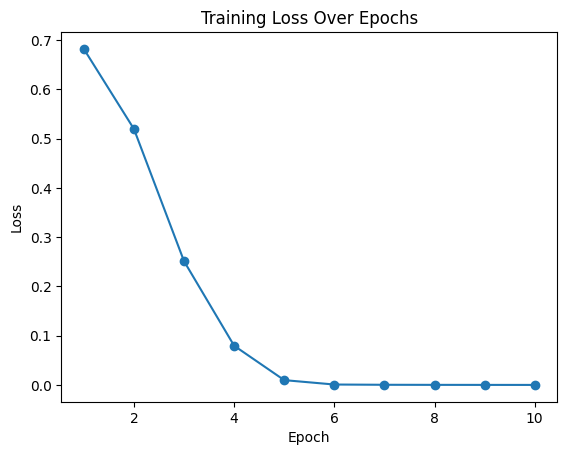

In [ ]:
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()